# 2.3 Least Squares and Nearest Neighbors

### 2.3.3 From Least Squares to Nearest Neighbors

1. Generates 10 means $m_k$ from a bivariate Gaussian distrubition for each color:
   - $N((1, 0)^T, \textbf{I})$ for <span style="color: blue">BLUE</span>
   - $N((0, 1)^T, \textbf{I})$ for <span style="color: orange">ORANGE</span>
2. For each color generates 100 observations as following:
   - For each observation it picks $m_k$ at random with probability 1/10.
   - Then generates a $N(m_k,\textbf{I}/5)$


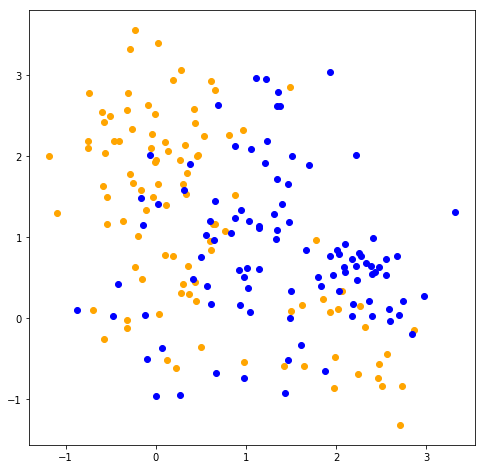

In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt

sample_size = 100

def generate_data(size, mean):
    identity = np.identity(2)
    m = np.random.multivariate_normal(mean, identity, 10)
    return np.array([
        np.random.multivariate_normal(random.choice(m), identity / 5)
        for _ in range(size)
    ])

def plot_data(orange_data, blue_data): 
    axes.plot(orange_data[:, 0], orange_data[:, 1], 'o', color='orange')
    axes.plot(blue_data[:, 0], blue_data[:, 1], 'o', color='blue')
    
blue_data = generate_data(sample_size, [1, 0])
orange_data = generate_data(sample_size, [0, 1])

# plotting
fig = plt.figure(figsize = (8, 8))
axes = fig.add_subplot(1, 1, 1)
plot_data(orange_data, blue_data)

plt.show()

### 2.3.1 Linear Models and Least Squares

$$\hat{Y} = \hat{\beta_0} + \sum_{j=1}^{p} X_j\hat{\beta_j}$$

where $\hat{\beta_0}$ is the intercept, also know as the *bias*. It is convenient to include the constant variable 1 in X and $\hat{\beta_0}$ in the vector of coefficients $\hat{\beta}$, and then write as: 

$$\hat{Y} = X^T\hat{\beta} $$

#### Residual sum of squares

How to fit the linear model to a set of training data? Pick the coefficients $\beta$ to minimize the *residual sum of squares*:

$$RSS(\beta) = \sum_{i=1}^{N} (y_i - x_i^T\beta) ^ 2 = (\textbf{y} - \textbf{X}\beta)^T (\textbf{y} - \textbf{X}\beta)$$

where $\textbf{X}$ is an $N \times p$ matrix with each row an input vector, and $\textbf{y}$ is an N-vector of the outputs in the training set. Differentiating w.r.t. β we get the normal equations:

$$\mathbf{X}^T(\mathbf{y} - \mathbf{X}\beta) = 0$$

If $\mathbf{X}^T\mathbf{X}$ is nonsingular, then the unique solution is given by: 

$$\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$



In [2]:
data_x = np.concatenate((blue_data, orange_data))
data_y = np.concatenate((np.zeros(sample_size), np.ones(sample_size))) 

X = np.hstack((np.ones((2 * sample_size, 1)), data_x))

beta = np.linalg.lstsq(X, data_y, rcond = None)[0]

print("beta = ", beta)

beta =  [ 0.70149963 -0.21159236 -0.00258385]


#### Example of the linear model in a classification context

The fitted values $\hat{Y}$ are converted to a fitted class variable $\hat{G}$ according to the rule:

$$
\begin{equation}
\hat{G} = \begin{cases}
\text{ORANGE} & \text{ if } \hat{Y} \gt 0.5 \\ 
\text{BLUE    } & \text{ if } \hat{Y} \leq 0.5 
\end{cases}
\end{equation}
$$

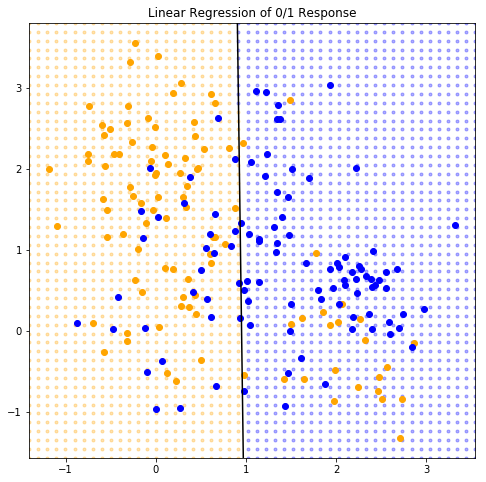

In [3]:
from itertools import filterfalse, product

def plot_grid(orange_grid, blue_grid):
    axes.plot(orange_grid[:, 0], orange_grid[:, 1], '.', zorder = 0.001,
          color='orange', alpha = 0.3, scalex = False, scaley = False)

    axes.plot(blue_grid[:, 0], blue_grid[:, 1], '.', zorder = 0.001,
          color='blue', alpha = 0.3, scalex = False, scaley = False)

plot_xlim = axes.get_xlim()
plot_ylim = axes.get_ylim()

grid = np.array([*product(np.linspace(*plot_xlim, 50), np.linspace(*plot_ylim, 50))])

is_orange = lambda x: np.dot(beta, [1, *x]) > 0.5

orange_grid = np.array([*filter(is_orange, grid)])
blue_grid = np.array([*filterfalse(is_orange, grid)])

axes.clear()
axes.set_title("Linear Regression of 0/1 Response")
plot_data(orange_data, blue_data)
plot_grid(orange_grid, blue_grid)

find_y = lambda x: (0.5 - beta[0] - x * beta[1]) / beta[2]
axes.plot(plot_xlim, [*map(find_y, plot_xlim)], color = 'black', 
          scalex = False, scaley = False)


fig

### 2.3.2 Nearest-Neighbor Methods

$$\hat{Y}(x) = \frac{1}{k} \sum_{x_i \in N_k(x)} y_i$$

where $N_k(x)$ is the neighborhood of $x$ defined by the $k$ closest points $x_i$ in the training sample.

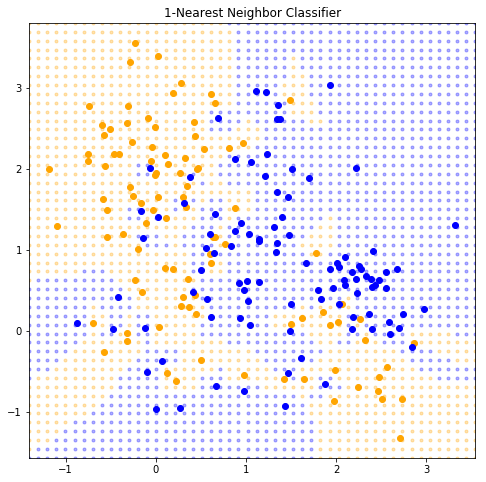

In [4]:
from scipy.spatial import distance
from heapq import nsmallest

def knearest(k, point, data_x, data_y):
    distances = ((data_x - point)**2).sum(axis=1)
    return np.mean(data_y[distances.argpartition(k)[:k]])

is_orange = lambda x: knearest(1, x, data_x, data_y) > 0.5
orange_grid = np.array([*filter(is_orange, grid)])
blue_grid = np.array([*filterfalse(is_orange, grid)])

axes.clear()
axes.set_title("1-Nearest Neighbor Classifier")

plot_data(orange_data, blue_data)
plot_grid(orange_grid, blue_grid)

fig

It appears that k-nearest-neighbor have a single parameter (*k*), however the effective number of parameters is N/k and is generally bigger than the p parameters in least-squares fits. **Note:** if the neighborhoods
were nonoverlapping, there would be N/k neighborhoods and we would fit one parameter (a mean) in each neighborhood.

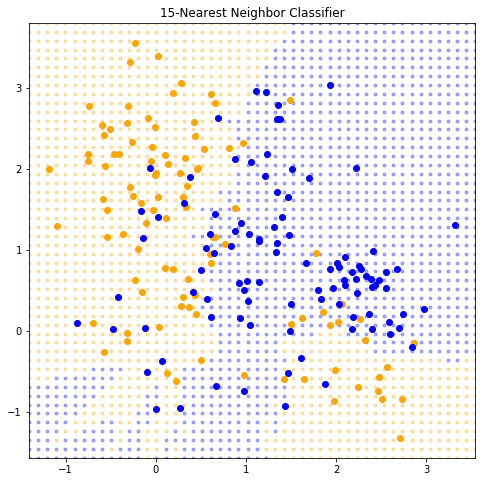

In [5]:
is_orange = lambda x: knearest(15, x, data_x, data_y) > 0.5
orange_grid = np.array([*filter(is_orange, grid)])
blue_grid = np.array([*filterfalse(is_orange, grid)])

axes.clear()
axes.set_title("15-Nearest Neighbor Classifier")

plot_data(orange_data, blue_data)
plot_grid(orange_grid, blue_grid)

fig